In [ ]:
!pip install -U tensorflow-io==0.16.0
# restart runtime
os.kill(os.getpid(), 9)

# **Libraries & Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
import sys
import random
import pandas as pd
# from IPython.display import display
from IPython import display
pd.options.display.max_columns = None
import numpy as np
import datetime
import time

import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use("dark_background")

import tensorflow_io as tfio
import tensorflow as tf
import tensorflow.keras.backend as K
print(tf.__version__)


Mounted at /content/drive/
2.3.4


## **LGG**

In [ ]:
LGG_mask = glob('/content/drive/My Drive/Nam4_HK2/LV_CT595/BTLiem_Pix2Pix_DHYD_BaiBaoKhoaHoc/kaggle_3m_Cropped/*/*_mask*')
LGG_files = [file.replace('_mask', '') for file in LGG_mask]
print(LGG_files)
print(LGG_mask)
print(len(LGG_files))

def diagnosis(mask_path):
  value = np.max(cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE))
  return 1 if value > 0 else 0

START_NAME = 52 #len(/content/drive/My Drive/Nam4_HK2/LV_CT595/kaggle_3m/<---/TCGA_CS_5397_20010315_4.tif)
LEN_NAME = 21 #len(TCGA_CS_5397_20010315)

def patient(mask_path, START_NAME, LEN_NAME):
  return mask_path[START_NAME:START_NAME+LEN_NAME]

df_LGG = pd.DataFrame({"patient": [patient(x, START_NAME, LEN_NAME) for x in LGG_mask],
                   "image_path": LGG_files,
                   "mask_path": LGG_mask,
                   "diagnosis":[diagnosis(x) for x in LGG_mask]})

df_LGG = df_LGG[df_LGG['diagnosis']==1]

df_LGG

## **LOAD DATA DHYD**

In [ ]:
mask_files = glob('/content/drive/My Drive/Nam4_HK2/LV_CT595/BTLiem_Pix2Pix_DHYD_BaiBaoKhoaHoc/Dataset_BenhVien_DHYD_toLGG_Processing/*/*FLAIR*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]
print(train_files)
print(mask_files)
print(len(train_files))
print(len(mask_files))


In [ ]:
def diagnosis(mask_path):
  value = np.max(cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE))
  return 1 if value > 0 else 0

# print(len('/content/drive/My Drive/Nam4_HK2/LV_CT595/Pix2Pix_DHYD_BaiBaoKhoaHoc/Dataset_BenhVien_DHYD_toLGG_Processing/')) #108
START_NAME = 108
LEN_NAME = 35 

def patient(mask_path, START_NAME, LEN_NAME):
  return mask_path[START_NAME:START_NAME+LEN_NAME]

df = pd.DataFrame({"patient": [patient(x, START_NAME, LEN_NAME) for x in mask_files],
                   "image_path": train_files,
                   "mask_path": mask_files,
                   "diagnosis":[diagnosis(x) for x in mask_files]})
df

## **Data Distribution & Visualization**

In [ ]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [ ]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# # Annotations
# for i, rows in enumerate(patients_by_diagnosis.values):
#     plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
#     plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua");


In [ ]:
# Visualization (3 positive - 2 negative)

sample_df_positive = df[df["diagnosis"] == 1].sample(3)
sample_df_negative = df[df["diagnosis"] == 0].sample(2)
sample_df = sample_df_positive.append(sample_df_negative, ignore_index=True).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(cv2.imread(data[2]), (512, 512))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr, cmap='gray')
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

## **Train/Test/Val**


Có tổng 139 BN - 106 BN co bat thuong

In [ ]:
list_patient = df['patient'].value_counts().index.tolist()
# print(len(list_patient))

import random
random.shuffle(list_patient)

# list_patient_val = list_patient[:10]
# list_patient_test = list_patient[10:30]
# list_patient_train = list_patient[30:]

# Lan 1
# list_patient_val = ['essing/TRỊNH THỊ QUẾ/Series_009', 'essing/BÙI MAI PHÚC THÁI/Series_', 'essing/VÕ VĂN BÁO/Series_019_Ax ', 'essing/HUỲNH TÚ HOA/Series_010_Ax', 'essing/NGUYỄN VĂN THANH/Series_0', 'essing/KIM THỊ HUỲNH LAN/Series_0', 'essing/NGUYỄN VĂN MINH/Series_00', 'essing/PHAN THANH NHÀN-LẦN 2/Ser', 'essing/DƯƠNG THỊ MUM/Series_007_', 'essing/LA THÀNH TRUNG/Series_006_A']

# list_patient_test = ['essing/PHAN THANH NHÀN/Series_007_', 'essing/TRẦN KIM THI/Series_016_Ax', 'essing/ĐẶNG THỊ LỆ/Series_006_', 'essing/NGUYỄN MINH HUẤN/Series_', 'essing/ĐỖ THỊ KIỀU LAM/Series_', 'essing/HUỲNH VĂN KIỆT- LẦN 2/', 'essing/NGUYỄN THANH NHÃ/Series_0', 'essing/TRẦN HỒNG SƠN/Series_00', 'essing/TRƯƠNG THỊ CẦM NHUNG/Se', 'essing/LÂM THỊ MINH CHÂU/Series_', 'essing/TRẦN VĂN DŨNG/Series_007', 'essing/NGUYỄN THỊ LAN/Series_006', 'essing/VÕ THANH TIẾN/Series_008_', 'essing/LÊ THỊ ÚT BA/Series_007_A', 'essing/PHẠM THỊ MỸ HẰNG/Series', 'essing/PHẠM QUYẾT TIẾN/Series_', 'essing/TRƯƠNG THANH TÙNG/Series_', 'essing/ĐẶNG PHẠM HOÀNG LÂM/Ser', 'essing/LÊ THỊ NHUNG/Series_007_Ax', 'essing/HUỲNH VĂN OANH/Series_016_']

# list_patient_train = ['essing/HUỲNH THỊ PHÚC/Series_007', 'essing/PHẠM THỊ TUYẾT HỒNG/Se', 'essing/TÔN KIM NGỌC/Series_008_Ax', 'essing/TRẦN THỊ CẤN/Series_007', 'essing/ĐẶNG THỊ HÒA/Series_011_', 'essing/NGUYỄN THỊ CÓ/Series_007', 'essing/ĐỖ THỊ THÚY VÂN/Series_', 'essing/NGUYỄN VĂN ĐÔNG/Series_0', 'essing/PHẠM VĂN TRƯỜNG/Series_', 'essing/TÔ THỊ BẠCH THU/Series_00', 'essing/TRẦN KIM THÚY/Series_021_', 'essing/NGUYỄN THỊ LÀNH/Series_0', 'essing/LÂM THỊ NÂU/Series_014_Ax', 'essing/TRƯƠNG THỊ NGHIÊM/Series', 'essing/CHẾ HỒNG NHIÊN/Series_0', 'essing/NGUYỄN VĂN LÔ/Series_006', 'essing/NGUYỄN VĂN THIỆN/Series', 'essing/ĐẶNG THỊ LỦY- LẦN 2/Se', 'essing/BÀNH THỊ DIỆU/Series_005', 'essing/TÔ THỊ LIÊN/Series_013_Ax', 'essing/ĐỖ THỊ THÚY/Series_003_A', 'essing/NGUYỄN VĂN MINH--/Series_', 'essing/ĐỖ THỊ MAI/Series_003_Ax ', 'essing/TRẦN VĂN OANH/Series_004_', 'essing/ĐẶNG THỊ LỦY/Series_006_', 'essing/NGUYỄN VĂN MUNG/Series_00', 'essing/NGUYỄN THỊ MỘNG TUYỀN', 'essing/ĐỖ THỊ SIỂM/Series_008_', 'essing/TRƯƠNG VĂN MƯỜI/Series', 'essing/LÊ PHƯƠNG TRINH/Series_00', 'essing/NGUYỄN THỊ MỸ HẰNG/Ser', 'essing/TRẦN THUYẾT SIÊU/Series', 'essing/NGUYỄN NGỌC BÌNH/Series_', 'essing/NGUYỄN NGỌC THÁI/Series_', 'essing/TRẦN VĂN THIẾT/Series_0', 'essing/TRẦN THỊ KHEN/Series_007_', 'essing/NGUYỄN KẾ NGHIỆP/Serie', 'essing/CHUNG VĂN LƯỢNG/Series_0', 'essing/PHAN VĂN SUÔL/Series_007_A', 'essing/DƯƠNG THỊ SÁU/Series_007', 'essing/NGUYỄN THỊ TÍM/Series_00', 'essing/LÝ THỊ HỒNG PHƯƠNG/Ser', 'essing/LÂM THANH HƠN/Series_008_A', 'essing/TRẦN THỊ HỒNG/Series_00', 'essing/LÊ THỊ THU BA/Series_007_A', 'essing/NGUYỄN BỬU TRẠNG/Series', 'essing/NGUYỄN THỊ KIM THI/Series', 'essing/LÊ VĂN ĐỔI/Series_007_Ax', 'essing/DƯƠNG THỊ LÀI/Series_013', 'essing/TRẦN THỊ ÁNH TUYẾT/Ser', 'essing/NGUYỄN THÀNH CHÓT/Series', 'essing/TRẦN VĂN ĐÁNG/Series_007', 'essing/BÙI THỊ THẢO EM- LẦN 2/', 'essing/ĐỔ THỊ CAM/Series_005_Ax ', 'essing/LÊ TUẤN ANH/Series_009_Ax', 'essing/DƯƠNG THỊ THƯƠNG/Series', 'essing/HUỲNH QUỐC HỘI/Series_0', 'essing/HUỲNH THỊ ANH/Series_012_A', 'essing/ĐỖ NGUYỄN VĂN AN/Series', 'essing/NGÔ KIM HÔN/Series_015_Ax ', 'essing/NGUYỄN VĂN MẾN/Series_0', 'essing/HUỲNH VĂN MAI/Series_006_A', 'essing/TRẦN VĂN LINH/Series_007_', 'essing/NGUYỄN THỊ HAI/Series_012', 'essing/TRẦN THỊ SỶ/Series_006_A', 'essing/NGUYỄN THỊ BÍCH NGUYÊN/', 'essing/MAI NGHÉT/Series_017_Ax T2 ', 'essing/TRƯƠNG THỊ LẮM/Series_0', 'essing/HUỲNH VĂN KIỆT/Series_00', 'essing/NGUYỄN QUỐC ĐẠI/Series_', 'essing/NGUYỄN THỊ ÚT/Series_004', 'essing/ĐÀO VĂN THẮM/Series_008_', 'essing/NGUYỄN THỊ THANG/Series_0', 'essing/PHẠM VĂN BẢY/Series_012_A', 'essing/CHÂU THỊ TUYẾT/Series_00', 'essing/NGUYỄN HOÀNG ÂN/Series_0']
# 406/110

# # Lan 2
# list_patient_val = ['essing/NGUYỄN THỊ THANG/Series_0', 'essing/NGUYỄN VĂN MINH/Series_00', 'essing/NGUYỄN THỊ LÀNH/Series_0', 'essing/TRẦN KIM THI/Series_016_Ax', 'essing/DƯƠNG THỊ LÀI/Series_013', 'essing/PHAN THANH NHÀN-LẦN 2/Ser', 'essing/ĐẶNG THỊ LỦY/Series_006_', 'essing/TRẦN THỊ KHEN/Series_007_', 'essing/ĐỔ THỊ CAM/Series_005_Ax ', 'essing/HUỲNH THỊ ANH/Series_012_A']

# list_patient_test = ['essing/NGUYỄN NGỌC BÌNH/Series_', 'essing/TRƯƠNG THỊ CẦM NHUNG/Se', 'essing/TRƯƠNG THỊ NGHIÊM/Series', 'essing/HUỲNH VĂN MAI/Series_006_A', 'essing/NGUYỄN THỊ ÚT/Series_004', 'essing/ĐỖ NGUYỄN VĂN AN/Series', 'essing/ĐÀO VĂN THẮM/Series_008_', 'essing/HUỲNH VĂN KIỆT/Series_00', 'essing/LÊ TUẤN ANH/Series_009_Ax', 'essing/PHẠM QUYẾT TIẾN/Series_', 'essing/TRẦN VĂN ĐÁNG/Series_007', 'essing/NGÔ KIM HÔN/Series_015_Ax ', 'essing/TÔN KIM NGỌC/Series_008_Ax', 'essing/TRẦN THỊ HỒNG/Series_00', 'essing/TRƯƠNG THỊ LẮM/Series_0', 'essing/NGUYỄN THỊ KIM THI/Series', 'essing/LÊ VĂN ĐỔI/Series_007_Ax', 'essing/ĐỖ THỊ MAI/Series_003_Ax ', 'essing/LÊ PHƯƠNG TRINH/Series_00', 'essing/PHẠM THỊ MỸ HẰNG/Series']

# list_patient_train = ['essing/ĐẶNG PHẠM HOÀNG LÂM/Ser', 'essing/HUỲNH QUỐC HỘI/Series_0', 'essing/NGUYỄN VĂN MINH--/Series_', 'essing/TRẦN VĂN OANH/Series_004_', 'essing/ĐẶNG THỊ LỦY- LẦN 2/Se', 'essing/BÙI THỊ THẢO EM- LẦN 2/', 'essing/TRƯƠNG THANH TÙNG/Series_', 'essing/NGUYỄN THỊ HAI/Series_012', 'essing/NGUYỄN THỊ LAN/Series_006', 'essing/NGUYỄN THỊ MỸ HẰNG/Ser', 'essing/LÊ THỊ NHUNG/Series_007_Ax', 'essing/DƯƠNG THỊ MUM/Series_007_', 'essing/KIM THỊ HUỲNH LAN/Series_0', 'essing/ĐẶNG THỊ LỆ/Series_006_', 'essing/ĐỖ THỊ KIỀU LAM/Series_', 'essing/CHUNG VĂN LƯỢNG/Series_0', 'essing/TÔ THỊ BẠCH THU/Series_00', 'essing/TRẦN THUYẾT SIÊU/Series', 'essing/TRẦN HỒNG SƠN/Series_00', 'essing/CHẾ HỒNG NHIÊN/Series_0', 'essing/BÙI MAI PHÚC THÁI/Series_', 'essing/ĐỖ THỊ THÚY VÂN/Series_', 'essing/ĐẶNG THỊ HÒA/Series_011_', 'essing/PHẠM VĂN TRƯỜNG/Series_', 'essing/LÂM THỊ NÂU/Series_014_Ax', 'essing/HUỲNH VĂN OANH/Series_016_', 'essing/NGUYỄN VĂN ĐÔNG/Series_0', 'essing/NGUYỄN VĂN MẾN/Series_0', 'essing/NGUYỄN QUỐC ĐẠI/Series_', 'essing/TÔ THỊ LIÊN/Series_013_Ax', 'essing/LÂM THỊ MINH CHÂU/Series_', 'essing/DƯƠNG THỊ THƯƠNG/Series', 'essing/NGUYỄN THỊ CÓ/Series_007', 'essing/NGUYỄN MINH HUẤN/Series_', 'essing/PHAN THANH NHÀN/Series_007_', 'essing/TRẦN THỊ SỶ/Series_006_A', 'essing/LÝ THỊ HỒNG PHƯƠNG/Ser', 'essing/TRẦN VĂN LINH/Series_007_', 'essing/NGUYỄN THỊ MỘNG TUYỀN', 'essing/NGUYỄN VĂN THANH/Series_0', 'essing/NGUYỄN HOÀNG ÂN/Series_0', 'essing/MAI NGHÉT/Series_017_Ax T2 ', 'essing/DƯƠNG THỊ SÁU/Series_007', 'essing/HUỲNH TÚ HOA/Series_010_Ax', 'essing/NGUYỄN THỊ TÍM/Series_00', 'essing/NGUYỄN VĂN THIỆN/Series', 'essing/PHAN VĂN SUÔL/Series_007_A', 'essing/VÕ THANH TIẾN/Series_008_', 'essing/NGUYỄN BỬU TRẠNG/Series', 'essing/NGUYỄN VĂN MUNG/Series_00', 'essing/NGUYỄN THỊ BÍCH NGUYÊN/', 'essing/TRƯƠNG VĂN MƯỜI/Series', 'essing/ĐỖ THỊ SIỂM/Series_008_', 'essing/HUỲNH THỊ PHÚC/Series_007', 'essing/PHẠM VĂN BẢY/Series_012_A', 'essing/NGUYỄN NGỌC THÁI/Series_', 'essing/LÊ THỊ ÚT BA/Series_007_A', 'essing/LA THÀNH TRUNG/Series_006_A', 'essing/NGUYỄN KẾ NGHIỆP/Serie', 'essing/BÀNH THỊ DIỆU/Series_005', 'essing/NGUYỄN VĂN LÔ/Series_006', 'essing/PHẠM THỊ TUYẾT HỒNG/Se', 'essing/TRẦN THỊ CẤN/Series_007', 'essing/LÂM THANH HƠN/Series_008_A', 'essing/ĐỖ THỊ THÚY/Series_003_A', 'essing/TRẦN THỊ ÁNH TUYẾT/Ser', 'essing/CHÂU THỊ TUYẾT/Series_00', 'essing/VÕ VĂN BÁO/Series_019_Ax ', 'essing/NGUYỄN THANH NHÃ/Series_0', 'essing/NGUYỄN THÀNH CHÓT/Series', 'essing/TRẦN VĂN THIẾT/Series_0', 'essing/TRẦN KIM THÚY/Series_021_', 'essing/LÊ THỊ THU BA/Series_007_A', 'essing/TRỊNH THỊ QUẾ/Series_009', 'essing/HUỲNH VĂN KIỆT- LẦN 2/', 'essing/TRẦN VĂN DŨNG/Series_007']
# # (410, 4) (104, 4)

# # Lan 3
# list_patient_val = ['essing/PHẠM THỊ MỸ HẰNG/Series', 'essing/VÕ THANH TIẾN/Series_008_', 'essing/DƯƠNG THỊ MUM/Series_007_', 'essing/NGUYỄN THỊ MỘNG TUYỀN', 'essing/NGUYỄN THỊ ÚT/Series_004', 'essing/LÊ THỊ NHUNG/Series_007_Ax', 'essing/BÀNH THỊ DIỆU/Series_005', 'essing/LÊ VĂN ĐỔI/Series_007_Ax', 'essing/HUỲNH THỊ PHÚC/Series_007', 'essing/NGUYỄN THỊ TÍM/Series_00']

# list_patient_test = ['essing/NGUYỄN VĂN MINH/Series_00', 'essing/NGUYỄN THỊ CÓ/Series_007', 'essing/PHAN THANH NHÀN/Series_007_', 'essing/LÂM THANH HƠN/Series_008_A', 'essing/ĐẶNG THỊ HÒA/Series_011_', 'essing/TRẦN VĂN LINH/Series_007_', 'essing/DƯƠNG THỊ SÁU/Series_007', 'essing/LÊ THỊ ÚT BA/Series_007_A', 'essing/TRẦN THỊ CẤN/Series_007', 'essing/TRƯƠNG VĂN MƯỜI/Series', 'essing/LÝ THỊ HỒNG PHƯƠNG/Ser', 'essing/ĐỖ THỊ THÚY VÂN/Series_', 'essing/NGUYỄN THỊ BÍCH NGUYÊN/', 'essing/NGUYỄN VĂN THANH/Series_0', 'essing/HUỲNH VĂN KIỆT- LẦN 2/', 'essing/ĐẶNG THỊ LỆ/Series_006_', 'essing/TRẦN VĂN THIẾT/Series_0', 'essing/TRƯƠNG THANH TÙNG/Series_', 'essing/NGUYỄN VĂN LÔ/Series_006', 'essing/ĐỖ NGUYỄN VĂN AN/Series']

# list_patient_train = ['essing/NGUYỄN THỊ THANG/Series_0', 'essing/PHAN VĂN SUÔL/Series_007_A', 'essing/PHẠM VĂN BẢY/Series_012_A', 'essing/TRƯƠNG THỊ LẮM/Series_0', 'essing/PHAN THANH NHÀN-LẦN 2/Ser', 'essing/NGUYỄN THỊ LAN/Series_006', 'essing/NGUYỄN VĂN THIỆN/Series', 'essing/ĐỖ THỊ THÚY/Series_003_A', 'essing/TRẦN HỒNG SƠN/Series_00', 'essing/TRẦN VĂN OANH/Series_004_', 'essing/NGUYỄN KẾ NGHIỆP/Serie', 'essing/TÔ THỊ BẠCH THU/Series_00', 'essing/TRỊNH THỊ QUẾ/Series_009', 'essing/HUỲNH VĂN MAI/Series_006_A', 'essing/LÊ THỊ THU BA/Series_007_A', 'essing/NGUYỄN NGỌC BÌNH/Series_', 'essing/NGUYỄN THANH NHÃ/Series_0', 'essing/NGUYỄN BỬU TRẠNG/Series', 'essing/TRẦN KIM THÚY/Series_021_', 'essing/VÕ VĂN BÁO/Series_019_Ax ', 'essing/BÙI MAI PHÚC THÁI/Series_', 'essing/NGUYỄN VĂN MUNG/Series_00', 'essing/BÙI THỊ THẢO EM- LẦN 2/', 'essing/DƯƠNG THỊ THƯƠNG/Series', 'essing/LÊ PHƯƠNG TRINH/Series_00', 'essing/TÔ THỊ LIÊN/Series_013_Ax', 'essing/ĐẶNG THỊ LỦY/Series_006_', 'essing/ĐỖ THỊ SIỂM/Series_008_', 'essing/CHẾ HỒNG NHIÊN/Series_0', 'essing/NGUYỄN VĂN MINH--/Series_', 'essing/NGUYỄN QUỐC ĐẠI/Series_', 'essing/TRẦN VĂN ĐÁNG/Series_007', 'essing/NGUYỄN VĂN ĐÔNG/Series_0', 'essing/NGUYỄN MINH HUẤN/Series_', 'essing/LÂM THỊ MINH CHÂU/Series_', 'essing/CHUNG VĂN LƯỢNG/Series_0', 'essing/ĐỔ THỊ CAM/Series_005_Ax ', 'essing/DƯƠNG THỊ LÀI/Series_013', 'essing/NGUYỄN THỊ MỸ HẰNG/Ser', 'essing/TÔN KIM NGỌC/Series_008_Ax', 'essing/NGUYỄN NGỌC THÁI/Series_', 'essing/HUỲNH QUỐC HỘI/Series_0', 'essing/NGUYỄN THỊ KIM THI/Series', 'essing/NGUYỄN THÀNH CHÓT/Series', 'essing/ĐỖ THỊ MAI/Series_003_Ax ', 'essing/NGUYỄN HOÀNG ÂN/Series_0', 'essing/TRƯƠNG THỊ NGHIÊM/Series', 'essing/HUỲNH VĂN KIỆT/Series_00', 'essing/ĐẶNG THỊ LỦY- LẦN 2/Se', 'essing/TRẦN THỊ SỶ/Series_006_A', 'essing/TRƯƠNG THỊ CẦM NHUNG/Se', 'essing/HUỲNH THỊ ANH/Series_012_A', 'essing/ĐỖ THỊ KIỀU LAM/Series_', 'essing/HUỲNH VĂN OANH/Series_016_', 'essing/NGUYỄN THỊ LÀNH/Series_0', 'essing/PHẠM VĂN TRƯỜNG/Series_', 'essing/HUỲNH TÚ HOA/Series_010_Ax', 'essing/MAI NGHÉT/Series_017_Ax T2 ', 'essing/PHẠM QUYẾT TIẾN/Series_', 'essing/TRẦN THỊ HỒNG/Series_00', 'essing/PHẠM THỊ TUYẾT HỒNG/Se', 'essing/TRẦN THỊ KHEN/Series_007_', 'essing/LÊ TUẤN ANH/Series_009_Ax', 'essing/TRẦN THUYẾT SIÊU/Series', 'essing/ĐÀO VĂN THẮM/Series_008_', 'essing/NGUYỄN VĂN MẾN/Series_0', 'essing/TRẦN VĂN DŨNG/Series_007', 'essing/CHÂU THỊ TUYẾT/Series_00', 'essing/TRẦN KIM THI/Series_016_Ax', 'essing/KIM THỊ HUỲNH LAN/Series_0', 'essing/TRẦN THỊ ÁNH TUYẾT/Ser', 'essing/ĐẶNG PHẠM HOÀNG LÂM/Ser', 'essing/NGÔ KIM HÔN/Series_015_Ax ', 'essing/NGUYỄN THỊ HAI/Series_012', 'essing/LA THÀNH TRUNG/Series_006_A', 'essing/LÂM THỊ NÂU/Series_014_Ax']
# # (407, 4) (117, 4)

# Lan 4
# list_patient_val = ['essing/NGUYỄN THỊ THANG/Series_0', 'essing/TRẦN THỊ CẤN/Series_007', 'essing/ĐẶNG PHẠM HOÀNG LÂM/Ser', 'essing/VÕ VĂN BÁO/Series_019_Ax ', 'essing/NGUYỄN THỊ MỘNG TUYỀN', 'essing/ĐỖ THỊ THÚY VÂN/Series_', 'essing/TRỊNH THỊ QUẾ/Series_009', 'essing/TRẦN THỊ SỶ/Series_006_A', 'essing/ĐỖ THỊ MAI/Series_003_Ax ', 'essing/BÙI THỊ THẢO EM- LẦN 2/']

# list_patient_test = ['essing/ĐẶNG THỊ LỆ/Series_006_', 'essing/LÊ THỊ ÚT BA/Series_007_A', 'essing/TÔN KIM NGỌC/Series_008_Ax', 'essing/PHẠM QUYẾT TIẾN/Series_', 'essing/NGUYỄN THỊ TÍM/Series_00', 'essing/TRƯƠNG THANH TÙNG/Series_', 'essing/NGUYỄN VĂN MẾN/Series_0', 'essing/ĐẶNG THỊ LỦY/Series_006_', 'essing/ĐỔ THỊ CAM/Series_005_Ax ', 'essing/NGUYỄN NGỌC BÌNH/Series_', 'essing/HUỲNH VĂN MAI/Series_006_A', 'essing/DƯƠNG THỊ SÁU/Series_007', 'essing/PHẠM THỊ MỸ HẰNG/Series', 'essing/NGUYỄN VĂN LÔ/Series_006', 'essing/TRẦN VĂN ĐÁNG/Series_007', 'essing/NGUYỄN KẾ NGHIỆP/Serie', 'essing/PHAN THANH NHÀN-LẦN 2/Ser', 'essing/CHUNG VĂN LƯỢNG/Series_0', 'essing/CHẾ HỒNG NHIÊN/Series_0', 'essing/NGUYỄN THỊ CÓ/Series_007']

# list_patient_train = ['essing/HUỲNH VĂN KIỆT/Series_00', 'essing/TRẦN THUYẾT SIÊU/Series', 'essing/HUỲNH VĂN KIỆT- LẦN 2/', 'essing/LA THÀNH TRUNG/Series_006_A', 'essing/LÊ VĂN ĐỔI/Series_007_Ax', 'essing/LÊ THỊ NHUNG/Series_007_Ax', 'essing/TRẦN VĂN LINH/Series_007_', 'essing/NGUYỄN THỊ BÍCH NGUYÊN/', 'essing/ĐỖ THỊ THÚY/Series_003_A', 'essing/PHẠM VĂN TRƯỜNG/Series_', 'essing/LÂM THỊ NÂU/Series_014_Ax', 'essing/ĐỖ NGUYỄN VĂN AN/Series', 'essing/NGUYỄN THÀNH CHÓT/Series', 'essing/HUỲNH TÚ HOA/Series_010_Ax', 'essing/DƯƠNG THỊ THƯƠNG/Series', 'essing/KIM THỊ HUỲNH LAN/Series_0', 'essing/TÔ THỊ BẠCH THU/Series_00', 'essing/NGUYỄN QUỐC ĐẠI/Series_', 'essing/NGUYỄN THỊ LAN/Series_006', 'essing/LÂM THANH HƠN/Series_008_A', 'essing/BÙI MAI PHÚC THÁI/Series_', 'essing/DƯƠNG THỊ MUM/Series_007_', 'essing/VÕ THANH TIẾN/Series_008_', 'essing/ĐẶNG THỊ HÒA/Series_011_', 'essing/NGUYỄN THỊ ÚT/Series_004', 'essing/ĐÀO VĂN THẮM/Series_008_', 'essing/PHAN VĂN SUÔL/Series_007_A', 'essing/TRẦN KIM THÚY/Series_021_', 'essing/LÝ THỊ HỒNG PHƯƠNG/Ser', 'essing/LÂM THỊ MINH CHÂU/Series_', 'essing/TRẦN THỊ HỒNG/Series_00', 'essing/TRẦN THỊ ÁNH TUYẾT/Ser', 'essing/LÊ PHƯƠNG TRINH/Series_00', 'essing/NGUYỄN THỊ LÀNH/Series_0', 'essing/TRƯƠNG VĂN MƯỜI/Series', 'essing/MAI NGHÉT/Series_017_Ax T2 ', 'essing/NGUYỄN THỊ KIM THI/Series', 'essing/TRƯƠNG THỊ LẮM/Series_0', 'essing/LÊ THỊ THU BA/Series_007_A', 'essing/TRƯƠNG THỊ NGHIÊM/Series', 'essing/HUỲNH THỊ ANH/Series_012_A', 'essing/LÊ TUẤN ANH/Series_009_Ax', 'essing/TRẦN VĂN OANH/Series_004_', 'essing/NGUYỄN HOÀNG ÂN/Series_0', 'essing/NGUYỄN NGỌC THÁI/Series_', 'essing/NGUYỄN VĂN MINH/Series_00', 'essing/ĐỖ THỊ SIỂM/Series_008_', 'essing/NGUYỄN VĂN THANH/Series_0', 'essing/ĐỖ THỊ KIỀU LAM/Series_', 'essing/HUỲNH THỊ PHÚC/Series_007', 'essing/TRẦN HỒNG SƠN/Series_00', 'essing/NGUYỄN THỊ MỸ HẰNG/Ser', 'essing/DƯƠNG THỊ LÀI/Series_013', 'essing/NGUYỄN MINH HUẤN/Series_', 'essing/TRẦN VĂN DŨNG/Series_007', 'essing/PHAN THANH NHÀN/Series_007_', 'essing/TRẦN THỊ KHEN/Series_007_', 'essing/PHẠM THỊ TUYẾT HỒNG/Se', 'essing/BÀNH THỊ DIỆU/Series_005', 'essing/TRẦN VĂN THIẾT/Series_0', 'essing/NGUYỄN THỊ HAI/Series_012', 'essing/TÔ THỊ LIÊN/Series_013_Ax', 'essing/NGUYỄN VĂN MINH--/Series_', 'essing/HUỲNH VĂN OANH/Series_016_', 'essing/TRƯƠNG THỊ CẦM NHUNG/Se', 'essing/NGUYỄN VĂN ĐÔNG/Series_0', 'essing/TRẦN KIM THI/Series_016_Ax', 'essing/ĐẶNG THỊ LỦY- LẦN 2/Se', 'essing/NGUYỄN THANH NHÃ/Series_0', 'essing/NGUYỄN VĂN THIỆN/Series', 'essing/CHÂU THỊ TUYẾT/Series_00', 'essing/PHẠM VĂN BẢY/Series_012_A', 'essing/HUỲNH QUỐC HỘI/Series_0', 'essing/NGUYỄN BỬU TRẠNG/Series', 'essing/NGÔ KIM HÔN/Series_015_Ax ', 'essing/NGUYỄN VĂN MUNG/Series_00']

# Lan 5
list_patient_val = ['essing/NGUYỄN THỊ TÍM/Series_00', 'essing/KIM THỊ HUỲNH LAN/Series_0', 'essing/TRẦN THỊ ÁNH TUYẾT/Ser', 'essing/ĐẶNG PHẠM HOÀNG LÂM/Ser', 'essing/PHẠM QUYẾT TIẾN/Series_', 'essing/NGUYỄN THỊ KIM THI/Series', 'essing/NGUYỄN HOÀNG ÂN/Series_0', 'essing/LÊ PHƯƠNG TRINH/Series_00', 'essing/NGUYỄN BỬU TRẠNG/Series', 'essing/PHẠM THỊ TUYẾT HỒNG/Se']

list_patient_test = ['essing/NGUYỄN THỊ LAN/Series_006', 'essing/MAI NGHÉT/Series_017_Ax T2 ', 'essing/TRẦN KIM THÚY/Series_021_', 'essing/TRẦN VĂN ĐÁNG/Series_007', 'essing/NGUYỄN THỊ ÚT/Series_004', 'essing/DƯƠNG THỊ LÀI/Series_013', 'essing/NGUYỄN VĂN THIỆN/Series', 'essing/PHAN THANH NHÀN-LẦN 2/Ser', 'essing/CHẾ HỒNG NHIÊN/Series_0', 'essing/NGUYỄN NGỌC BÌNH/Series_', 'essing/CHUNG VĂN LƯỢNG/Series_0', 'essing/CHÂU THỊ TUYẾT/Series_00', 'essing/ĐẶNG THỊ LỆ/Series_006_', 'essing/TRẦN HỒNG SƠN/Series_00', 'essing/LA THÀNH TRUNG/Series_006_A', 'essing/NGUYỄN THỊ BÍCH NGUYÊN/', 'essing/HUỲNH QUỐC HỘI/Series_0', 'essing/NGUYỄN VĂN MUNG/Series_00', 'essing/PHẠM VĂN TRƯỜNG/Series_', 'essing/NGUYỄN VĂN LÔ/Series_006']

list_patient_train = ['essing/TRƯƠNG THANH TÙNG/Series_', 'essing/ĐỖ THỊ THÚY VÂN/Series_', 'essing/HUỲNH VĂN MAI/Series_006_A', 'essing/TRƯƠNG THỊ CẦM NHUNG/Se', 'essing/ĐẶNG THỊ LỦY/Series_006_', 'essing/NGUYỄN MINH HUẤN/Series_', 'essing/TRỊNH THỊ QUẾ/Series_009', 'essing/LÝ THỊ HỒNG PHƯƠNG/Ser', 'essing/DƯƠNG THỊ THƯƠNG/Series', 'essing/LÂM THANH HƠN/Series_008_A', 'essing/ĐỖ THỊ SIỂM/Series_008_', 'essing/BÀNH THỊ DIỆU/Series_005', 'essing/PHAN VĂN SUÔL/Series_007_A', 'essing/NGUYỄN THỊ LÀNH/Series_0', 'essing/NGUYỄN VĂN THANH/Series_0', 'essing/ĐỖ THỊ KIỀU LAM/Series_', 'essing/NGUYỄN NGỌC THÁI/Series_', 'essing/ĐỔ THỊ CAM/Series_005_Ax ', 'essing/TRƯƠNG THỊ NGHIÊM/Series', 'essing/NGUYỄN THỊ MỸ HẰNG/Ser', 'essing/TRẦN KIM THI/Series_016_Ax', 'essing/TRẦN THỊ CẤN/Series_007', 'essing/HUỲNH VĂN OANH/Series_016_', 'essing/NGUYỄN KẾ NGHIỆP/Serie', 'essing/LÊ THỊ NHUNG/Series_007_Ax', 'essing/TRƯƠNG THỊ LẮM/Series_0', 'essing/NGUYỄN THỊ MỘNG TUYỀN', 'essing/TÔN KIM NGỌC/Series_008_Ax', 'essing/NGUYỄN QUỐC ĐẠI/Series_', 'essing/TRẦN THỊ HỒNG/Series_00', 'essing/BÙI THỊ THẢO EM- LẦN 2/', 'essing/HUỲNH VĂN KIỆT- LẦN 2/', 'essing/ĐỖ NGUYỄN VĂN AN/Series', 'essing/PHẠM VĂN BẢY/Series_012_A', 'essing/NGUYỄN THỊ HAI/Series_012', 'essing/TRẦN THỊ KHEN/Series_007_', 'essing/NGUYỄN THANH NHÃ/Series_0', 'essing/LÂM THỊ NÂU/Series_014_Ax', 'essing/LÊ THỊ THU BA/Series_007_A', 'essing/NGUYỄN THÀNH CHÓT/Series', 'essing/DƯƠNG THỊ SÁU/Series_007', 'essing/TRẦN VĂN DŨNG/Series_007', 'essing/VÕ VĂN BÁO/Series_019_Ax ', 'essing/HUỲNH TÚ HOA/Series_010_Ax', 'essing/TÔ THỊ BẠCH THU/Series_00', 'essing/NGUYỄN VĂN MINH/Series_00', 'essing/HUỲNH THỊ ANH/Series_012_A', 'essing/TRẦN VĂN THIẾT/Series_0', 'essing/NGUYỄN VĂN MINH--/Series_', 'essing/ĐỖ THỊ THÚY/Series_003_A', 'essing/TRẦN THUYẾT SIÊU/Series', 'essing/ĐẶNG THỊ HÒA/Series_011_', 'essing/LÂM THỊ MINH CHÂU/Series_', 'essing/TRẦN VĂN OANH/Series_004_', 'essing/HUỲNH VĂN KIỆT/Series_00', 'essing/VÕ THANH TIẾN/Series_008_', 'essing/ĐÀO VĂN THẮM/Series_008_', 'essing/ĐỖ THỊ MAI/Series_003_Ax ', 'essing/NGUYỄN VĂN MẾN/Series_0', 'essing/NGÔ KIM HÔN/Series_015_Ax ', 'essing/NGUYỄN THỊ CÓ/Series_007', 'essing/LÊ THỊ ÚT BA/Series_007_A', 'essing/PHAN THANH NHÀN/Series_007_', 'essing/NGUYỄN THỊ THANG/Series_0', 'essing/TÔ THỊ LIÊN/Series_013_Ax', 'essing/BÙI MAI PHÚC THÁI/Series_', 'essing/PHẠM THỊ MỸ HẰNG/Series', 'essing/LÊ TUẤN ANH/Series_009_Ax', 'essing/TRƯƠNG VĂN MƯỜI/Series', 'essing/TRẦN VĂN LINH/Series_007_', 'essing/NGUYỄN VĂN ĐÔNG/Series_0', 'essing/DƯƠNG THỊ MUM/Series_007_', 'essing/LÊ VĂN ĐỔI/Series_007_Ax', 'essing/HUỲNH THỊ PHÚC/Series_007', 'essing/ĐẶNG THỊ LỦY- LẦN 2/Se', 'essing/TRẦN THỊ SỶ/Series_006_A']
# (408, 4) (136, 4)

print(list_patient_val)
print(len(list_patient_val))
print(list_patient_test)
print(len(list_patient_test))
print(list_patient_train)
print(len(list_patient_train))

# df_train: 76 
df_train = pd.DataFrame(columns=['patient', 'image_path', 'mask_path', 'diagnosis'])
for patient in list_patient_train:
  df_1patient = df[df['patient']==patient]
  df_train = pd.concat([df_train, df_1patient], ignore_index=True)

# df_val: 10 
df_val = pd.DataFrame(columns=['patient', 'image_path', 'mask_path', 'diagnosis'])
for patient in list_patient_val:
  df_1patient = df[df['patient']==patient]
  df_val = pd.concat([df_val, df_1patient], ignore_index=True)

# df_test: 20 
df_test = pd.DataFrame(columns=['patient', 'image_path', 'mask_path', 'diagnosis'])
for patient in list_patient_test:
  df_1patient = df[df['patient']==patient]
  df_test = pd.concat([df_test, df_1patient], ignore_index=True)




# Train tren anh co bat thuong
df_train = df_train[df_train['diagnosis']==1]
df_val = df_val[df_val['diagnosis']==1]
df_test = df_test[df_test['diagnosis']==1]

# shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)


print(df_train.shape, (df_train[df_train['diagnosis']==1]).shape)
print(df_val.shape, (df_val[df_val['diagnosis']==1]).shape)
print(df_test.shape, (df_test[df_test['diagnosis']==1]).shape)



## **Load Images/Masks with tf.data**

**Load test_image**

In [ ]:
########## Load IMG/MASK
def load_imagemask(path_image, path_mask):


  image = tf.io.read_file(path_image)
  image = tf.io.decode_jpeg(image)
  image = tf.image.resize(image, (256, 256)) #Resize (512->256)
  image = image[:,:,0]
  image = image[..., tf.newaxis]


  mask = tf.io.read_file(path_mask)
  mask = tf.io.decode_jpeg(mask)
  mask = tf.image.resize(mask, (256, 256))
  mask = mask[:,:,0]
  mask = mask[..., tf.newaxis]


  image = tf.cast(image, tf.float32)
  mask = tf.cast(mask, tf.float32)


  return image, mask


def load_imagemask_tif(path_image, path_mask):

  # image = cv2.imread(path_image, 1)
  # mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)


  image = tf.io.read_file(path_image)
  image = tfio.experimental.image.decode_tiff(image)
  # image = rgba2rgb(image) # (256,256,4) to (256,256,3)
  # image = tfio.experimental.color.rgba_to_rgb(image)
  image = tf.image.resize(image, (256, 256)) #Resize (512->256)
  image = image[:,:,0]
  image = image[..., tf.newaxis]

  mask = tf.io.read_file(path_mask)
  mask = tfio.experimental.image.decode_tiff(mask)
  # mask = tfio.experimental.color.rgba_to_rgb(mask)
  # mask = tfio.experimental.color.rgb_to_grayscale(mask)
  mask = tf.image.resize(mask, (256, 256))
  mask = mask[:,:,0]
  mask = mask[..., tf.newaxis]


  image = tf.cast(image, tf.float32)
  mask = tf.cast(mask, tf.float32)

  return image, mask



IMG, LABEL = load_imagemask(df_test['image_path'].tolist()[1], df_test['mask_path'][1])

# Casting to int for matplotlib to display the images and mask
plt.figure()
plt.imshow(IMG[:,:,0], cmap='gray')
plt.figure()
plt.imshow(LABEL[:,:,0], cmap='gray')

# print(IMG, LABEL)
print(K.max(IMG)) #0-255
print(K.max(LABEL))
print(IMG.shape)
print(LABEL.shape)



**Pre-processing and load dataset**

In [ ]:
# Standardize/Normalize  the images to [-1, 1]
def standardize(image, mask):
  image = (image - 127.5) / 127.5
  mask = (mask - 127.5) / 127.5

  return image, mask

# # [0,1]
# def standardize(image, mask):
#   image = image/255
#   mask = mask/255

#   return image, mask

def load_image_train_tif(path_image, path_mask):
  image, mask = load_imagemask_tif(path_image, path_mask)
  image, mask = standardize(image, mask)

  return image, mask  


def load_image_train(path_image, path_mask):
  image, mask = load_imagemask(path_image, path_mask)
  image, mask = standardize(image, mask)
  return image, mask



# Data Augmentation
def flip_left_right(input_image, real_image):
  input_image = tf.image.flip_left_right(input_image)
  real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image

def flip_up_down(input_image, real_image):
  input_image = tf.image.flip_up_down(input_image)
  real_image = tf.image.flip_up_down(real_image)
  return input_image, real_image

def rotation(input_image, real_image):
  input_image = tf.image.rot90(input_image)
  real_image = tf.image.rot90(real_image)
  return input_image, real_image


def Aug(input_image, real_image):
  if tf.random.uniform(()) >= 0.3:
    input_image, real_image = flip_left_right(input_image, real_image)
  elif tf.random.uniform(()) < 0.3 and tf.random.uniform(()) >= 0.6:
    input_image, real_image = flip_up_down(input_image, real_image)
  else:
     input_image, real_image = rotation(input_image, real_image)
  return input_image, real_image

**Build an input pipeline with `tf.data`**

In [ ]:
BATCH_SIZE = 64


train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'].tolist(), df_train['mask_path'].tolist()))
train_dataset = (train_dataset
                 .map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                )
print('dhyd_1: {}'.format(tf.data.experimental.cardinality(train_dataset)))


train_dataset_LGG = tf.data.Dataset.from_tensor_slices((df_LGG['image_path'].tolist(), df_LGG['mask_path'].tolist()))
train_dataset_LGG = (train_dataset_LGG
                 .map(load_image_train_tif, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                )
print('lgg_1: {}'.format(tf.data.experimental.cardinality(train_dataset_LGG)))

#LGG
train_dataset = train_dataset.concatenate(train_dataset_LGG)
print('dhyd_1+lgg_1: {}'.format(tf.data.experimental.cardinality(train_dataset)))

# Aug
aug_dataset = (train_dataset.map(Aug))

train_dataset = train_dataset.concatenate(aug_dataset)
print('AUG: {}'.format(tf.data.experimental.cardinality(train_dataset)))


train_dataset = (train_dataset.shuffle(320)
                              .batch(BATCH_SIZE, drop_remainder=True))

val_dataset = tf.data.Dataset.from_tensor_slices((df_val['image_path'].tolist(), df_val['mask_path'].tolist()))
val_dataset = (val_dataset
                 .map(load_image_train)
                 .batch(64)
                )

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'].tolist(), df_test['mask_path'].tolist()))
test_dataset = (test_dataset
                 .map(load_image_train)
                 .batch(1)
                )


print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(val_dataset))
print(tf.data.experimental.cardinality(test_dataset))




# Test
image_batch, labels_batch = next(iter(val_dataset.take(1)))
print(image_batch.shape)
print(labels_batch.shape)
IMG_Test = image_batch[0]
LABEL_Test = labels_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(IMG_Test), np.max(IMG_Test))
print(np.min(LABEL_Test), np.max(LABEL_Test))

# print(IMG_test)
# print(LABEL_test)
print(IMG_Test.shape)
print(LABEL_Test.shape)

plt.figure()
plt.imshow((IMG_Test[:,:,0]+1)/2, cmap='gray')
plt.figure()
plt.imshow((LABEL_Test[:,:,0]+1)/2, cmap='gray')


# tf.Tensor(56, shape=(), dtype=int64)
# tf.Tensor(2, shape=(), dtype=int64)
# tf.Tensor(65, shape=(), dtype=int64)

# **Hyperparameters**

In [ ]:
LAMBDA = 200
GAMMA = 1


#Learning rate
d_lr = 2e-4   
g_lr = 2e-4  

beta_1=0.5

# **MODEL GAN** - KIEN TRUC UNET

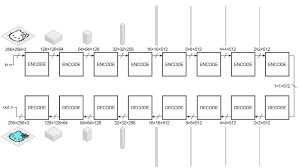

## **Generator**

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
_______________________________________________________________________________________

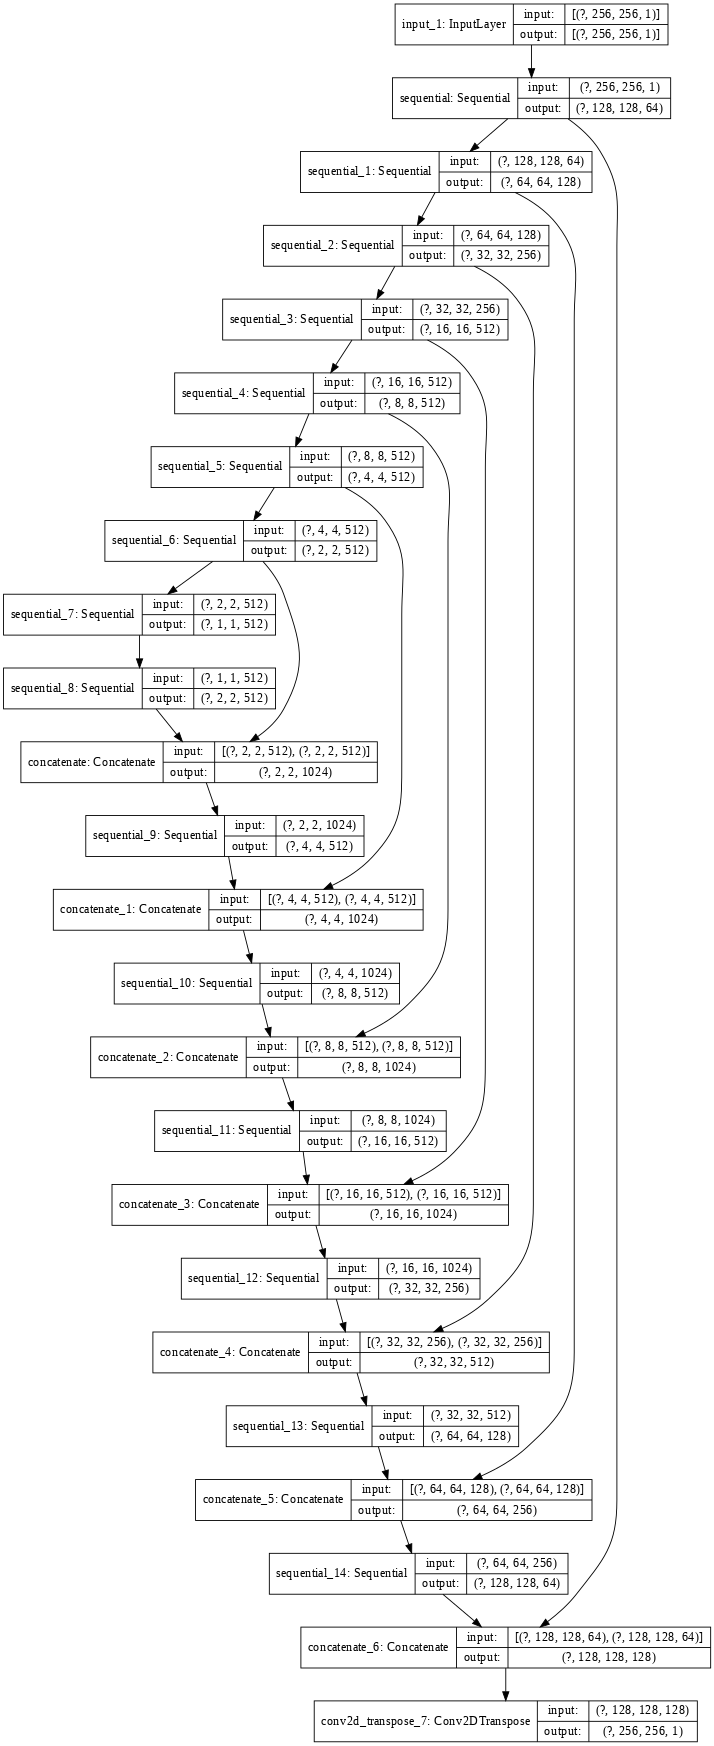

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
 
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
 
# define the standalone generator model
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)

    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Generator G
G = Generator()
G.summary()
tf.keras.utils.plot_model(G, show_shapes=True, dpi=64)


**Test Model Generator**

(1, 256, 256, 1)


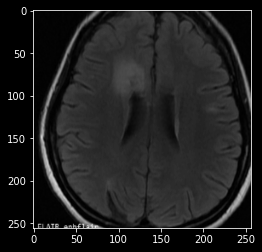

(1, 256, 256, 1)


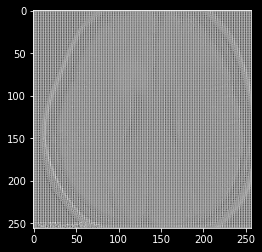

Original
(256, 256, 1)


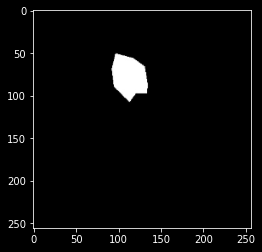

In [ ]:
# Standardization 
# Img_G_in = (IMG_Test - 127.5) / 127.5
# Img_G_in = IMG_Test/255.0   #Normalization 

gen_output = G(IMG_Test[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])
print(gen_output.shape)


# gen_output = np.squeeze(gen_output) #[0->1]
# gen_output = gen_output/ 1.0        #/255
# gen_output[gen_output > 0.5] = 1
# gen_output[gen_output <= 0.5] = 0


plt.imshow(IMG_Test[:,:,0],cmap='gray')
plt.show()

# Generated
# print(gen_output)
print(gen_output.shape)
plt.imshow(gen_output[0,:,:,0],cmap='gray')
plt.show()

# Original
print("Original")
print(LABEL_Test.shape)
plt.imshow(LABEL_Test[:,:,0],cmap='gray')
plt.show()

### **Generator Loss Funcion**

**Binary Cross-Entropy**

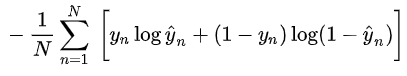


y_true = 0 => loss = log(1 - y_pred)

y_true = 1 => loss = log(y_pred)

**USING keras.backend - losses**

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error (MAE-L1)
  # l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # RMSE - L2
  l1_loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(target, gen_output))))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**Optimizers Funcion**

In [ ]:
#Optimizers G
generator_optimizer = tf.keras.optimizers.Adam(g_lr, beta_1=beta_1)

## **Discriminator**

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 2)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 2048        concatenate_7[0][0]   

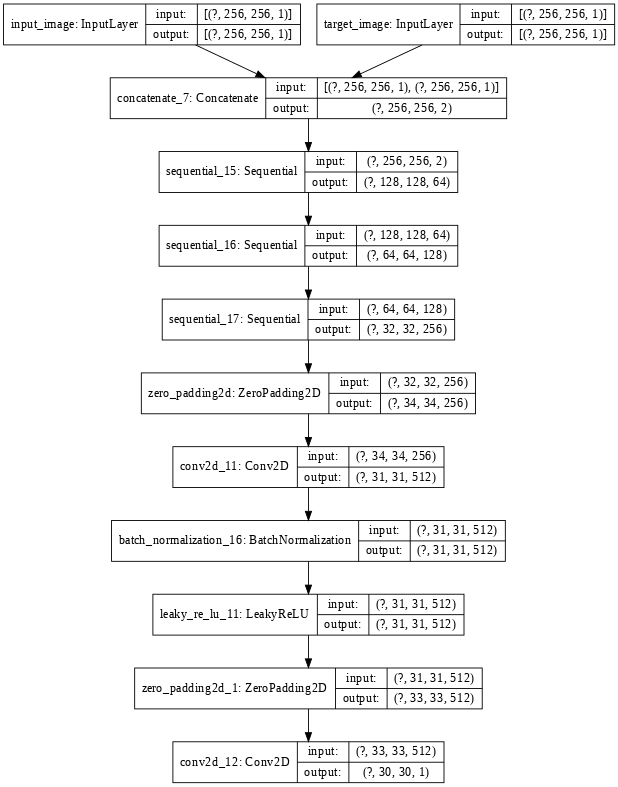

In [ ]:
# define the discriminator model
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


D = Discriminator()
D.summary()
tf.keras.utils.plot_model(D, show_shapes=True, dpi=64)

**Test Model Discriminator**

(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 30, 30, 1)
(1, 30, 30, 1)


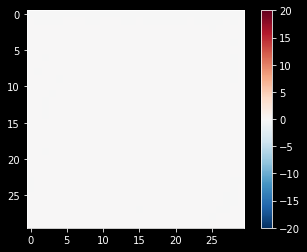

In [ ]:
# Test D_out

# Standardization 
# Img_in = (IMG_Test - 127.5) / 127.5
# Mask_in = LABEL_Test[:,:,0]
# Mask_in =  (LABEL_Test - 127.5) / 127.5
# Img_G_in = IMG_Test/255.0   #Normalization

#G_out
gen_output = G(IMG_Test[tf.newaxis, ...], training=False)
# print(LABEL_Test.shape)
# print(gen_output.shape)
# print(tf.expand_dims(LABEL_Test, axis=-1).shape)

#D_out

print(IMG_Test[tf.newaxis, ...].shape)
print(gen_output.shape)
disc_out = D([IMG_Test[tf.newaxis, ...], gen_output], training=False)

print(IMG_Test[tf.newaxis, ...].shape)
print(LABEL_Test[tf.newaxis, ...].shape)
disc_out_REAL = D([IMG_Test[tf.newaxis, ...], LABEL_Test[tf.newaxis, ...]], training=False)

print(disc_out.shape)
# print(disc_out[0, ..., -1])
print(disc_out_REAL.shape)
# print(disc_out_REAL[0, ..., -1])


plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**USING KERAS**

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + (GAMMA * generated_loss)

  return total_disc_loss

**Optimizer Funcion**

In [ ]:
#Optimizers D
discriminator_optimizer = tf.keras.optimizers.Adam(d_lr, beta_1=beta_1)

# **Generate images**

(52, 256, 256, 1) (52, 256, 256, 1)


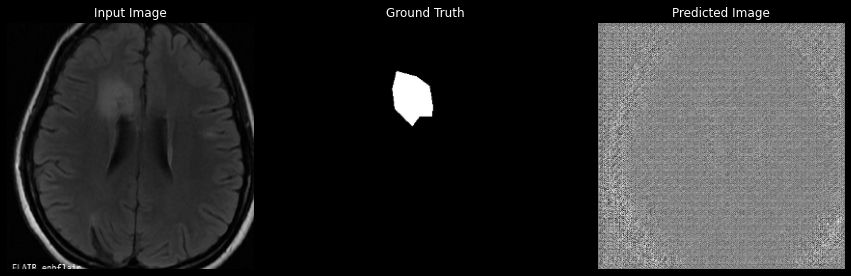

-1.0 1.0
-1.0 1.0


In [ ]:
def generate_images(model, test_input, tar):
  img = test_input[0]
  target = tar[0]

  prediction = model(test_input, training=True)
  prediction = prediction[:,:,:,0]

  a = np.array(prediction[0])

  plt.figure(figsize=(15, 15))

  display_list = [img[:,:,0], target[:,:,0], a]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()


example_input, example_target = next(iter(val_dataset.take(1)))
print(example_input.shape, example_input.shape)
generate_images(G, example_input, example_target)
print(np.min(example_input), np.max(example_input))
print(np.min(example_input), np.max(example_input))


# **Metrics Accuracy**

In [ ]:
# def dice_coef(y_true, y_pred):
#     y_truef=K.flatten(y_true)
#     y_predf=K.flatten(y_pred)
#     And=K.sum(y_truef* y_predf)
#     return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) ))

# def iou(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     sum_ = K.sum(y_true + y_pred)
#     jac = (intersection + smooth) / (sum_ - intersection)
#     return jac

# Precision = TruePositive / (TruePositive + FalsePositive)
def Precision(y_true, y_pred): #K phat. khi doan sai 0->1
  y_true = (y_true+1)/2   #[-1,1] to [0,1]
  y_pred = (y_pred+1)/2   #[-1,1] to [0,1]
  y_true = tf.cast((y_true >= 0.5), tf.float32) #> 0.5 = 1, <0.5 = 0
  y_pred = tf.cast((y_pred >= 0.5), tf.float32) #> 0.5 = 1, <0.5 = 0
  # print(y_true)
  # print(y_pred)
  #TruePositive
  TP = y_true*y_pred
  pr = K.sum(TP) / K.sum(y_true)
  if tf.math.is_nan(pr):
     pr = tf.constant(0.0)
  return pr

# iou = true_positives / (true_positives + false_positives + false_negatives)
def IoU(y_true, y_pred):
  y_true = (y_true+1)/2   #[-1,1] to [0,1]
  y_pred = (y_pred+1)/2   #[-1,1] to [0,1]
  y_true = tf.cast((y_true >= 0.5), tf.float32) #> 0.5 = 1, <0.5 = 0
  y_pred = tf.cast((y_pred >= 0.5), tf.float32) #> 0.5 = 1, <0.5 = 0
  TP = y_true*y_pred
  FN = tf.nn.relu(y_pred - y_true) # <0 => = 0
  iou = K.sum(TP) / (K.sum(y_true) + K.sum(FN))
  if tf.math.is_nan(iou):
    iou = tf.constant(0.0)
  return iou

# Dice similarity coefficient (DSC)
# DSC = 2TP / (2TP + FP + FN)


a = tf.constant([[0.0, -1, -0.75, 0], [0, 0, 0, 0]]) # 6 , 7
b = tf.constant([[0.0, 1, -1, 0], [0.5, 0, 1, -0.5]]) #5
print(Precision(a,b))
print(IoU(a,b))


tf.Tensor(0.8333333, shape=(), dtype=float32)
tf.Tensor(0.71428573, shape=(), dtype=float32)


# **CHECKPOINT**

In [ ]:
%cd /content/drive/My Drive/Nam4_HK2/LV_CT595/BTLiem_Pix2Pix_DHYD_BaiBaoKhoaHoc
# Save model
#step
checkpoint_dir = 'training_checkpoints/final/Lan5/'
checkpoint_prefix = os.path.join(checkpoint_dir+"step", "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator= G,
                                 discriminator= D)

#best
checkpoint_prefix_best = os.path.join(checkpoint_dir+"best", "ckpt")
checkpoint_best = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator= G,
                                 discriminator= D)

# Save history of loss funcion
log_dir="log/"

/content/drive/My Drive/Nam4_HK2/LV_CT595/BTLiem_Pix2Pix_DHYD_BaiBaoKhoaHoc


# **Training**

In [ ]:
@tf.function
# @tf.function(experimental_relax_shapes=True)
def train_step(input_image, target, step,  val_input, val_target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = G(input_image, training=True)

    disc_real_output = D([input_image, target], training=True)
    disc_generated_output = D([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, G.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, G.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, D.trainable_variables))

  #Metric
  G_val = G(val_input, training=True)
  iou_acc = IoU(val_target, G_val)
  precision_acc = Precision(val_target, G_val)


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//100)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//100)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//100)
    tf.summary.scalar('disc_loss', disc_loss, step=step//100)
    tf.summary.scalar('iou_acc', iou_acc, step=step//100)
    tf.summary.scalar('precision_acc', precision_acc, step=step//100)

  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, iou_acc, precision_acc 

In [ ]:
#train with step
def fit(train_ds, val_ds, steps):
  print("batch_size = {}, g_lr = {}, d_lr = {}, beta_1 = {}, LAMBDA = {} ".format(BATCH_SIZE,g_lr, d_lr, beta_1, LAMBDA))
  val_input, val_target = next(iter(val_ds.take(1)))

  start = time.time()

  min_GAN = 1000.0
  step_best = 0
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate(): # lay lan luot 1 batch_size theo thu tu trong n steps  (take: lay n batchsize, repeat: lap lai ds lai tu dau)
    if (step) % 100 == 0:
      # display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(G, example_input, example_target)
      print(f"Step: {step}")

    total_gen_loss, gen_gan_loss, gen_l1_loss, disc_loss, iou_acc, precision_acc = train_step(input_image, target, step, val_input, val_target)
    if total_gen_loss < min_GAN and step > 10000:
      min_GAN = total_gen_loss
      step_best = step
      # Save 
      checkpoint_best.save(file_prefix=checkpoint_prefix_best)
      print("best step: {}".format(step_best))
      print ('The best                 -             total_gen_loss : {} - gen_gan_loss: {} - gen_l1_loss: {}    ------ disc_loss: {}  ------- IOU: {} - precision_acc:  {}'.format(total_gen_loss, gen_gan_loss, gen_l1_loss, disc_loss, iou_acc, precision_acc))

      # save to .txt
      with open ('best_step.txt','w') as f:
        f.write('Best step:{}  -   total_gen_loss : {} - gen_gan_loss: {} - gen_l1_loss: {}    ------ disc_loss: {}  ------- IOU: {} - precision_acc:  {}'.format(step_best, total_gen_loss, gen_gan_loss, gen_l1_loss, disc_loss, iou_acc, precision_acc))
      
      
    if (step) % 100 == 0:
      print ('total_gen_loss : {} - gen_gan_loss: {} - gen_l1_loss: {}    ------ disc_loss: {}  ------- IOU: {} - precision_acc: {}'.format(total_gen_loss, gen_gan_loss, gen_l1_loss, disc_loss, iou_acc, precision_acc))

    # Training step
    if (step+1) % 1 == 0:
      print('.', end='', flush=True)


    # # Save (checkpoint) the model every 1k steps
    # if (step + 1) % 2000 == 0:
    #   checkpoint.save(file_prefix=checkpoint_prefix)

  print("best step: {}".format(step_best))


In [ ]:
# save history of loss funcion
summary_writer = tf.summary.create_file_writer(
  log_dir + "final/Lan4")


fit(train_dataset, val_dataset, 20001)  #6,6h    # Lan 4 Step: 11400

Output hidden; open in https://colab.research.google.com to view.

# **Restore the latest checkpoint and test the network**

**Run Tensorboard**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

In [ ]:
!ls {checkpoint_dir+"best"}

checkpoint		     ckpt-33.data-00000-of-00001
ckpt-30.data-00000-of-00001  ckpt-33.index
ckpt-30.index		     ckpt-34.data-00000-of-00001
ckpt-31.data-00000-of-00001  ckpt-34.index
ckpt-31.index		     ckpt-35.data-00000-of-00001
ckpt-32.data-00000-of-00001  ckpt-35.index
ckpt-32.index


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir+"best"))

# **Generate some images using the test set**

## **VAL**

In [ ]:
# Eval Val_ds
sum_Precision = 0.0
sum_IoU = 0.0
len_ds = 0
for img,tar in val_dataset:
  len_ds+=1
  g_out = G(img, training=True)
  pre = Precision(tar,g_out)
  sum_Precision += pre

  iou = IoU(tar,g_out)
  sum_IoU += iou
  print(pre)
  print(iou)

avr_Precision = sum_Precision/len_ds
avr_IoU = sum_IoU/len_ds
print(avr_Precision)
print(avr_IoU)

tf.Tensor(0.52014965, shape=(), dtype=float32)
tf.Tensor(0.48387977, shape=(), dtype=float32)
tf.Tensor(0.52014965, shape=(), dtype=float32)
tf.Tensor(0.48387977, shape=(), dtype=float32)


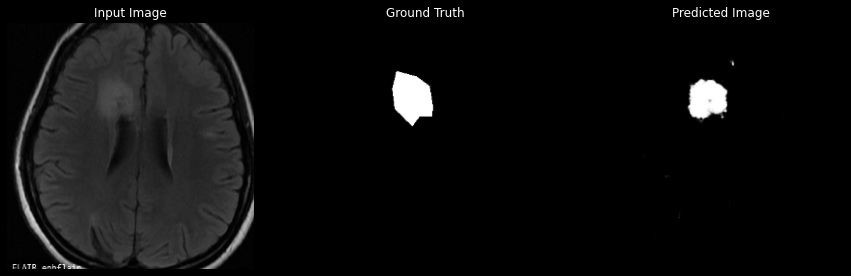

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in val_dataset.take(200):
  generate_images(G, inp, tar)

## **TEST**

In [ ]:
# Eval test_ds
sum_Precision = 0.0
sum_IoU = 0.0
len_ds = 0
for img,tar in test_dataset:
  g_out = G(img, training=True)
  pre = Precision(tar,g_out)

  iou = IoU(tar,g_out)
  print(pre)
  print(iou)
  if iou > 0:
    len_ds+=1
    sum_IoU += iou
    sum_Precision += pre

avr_Precision = sum_Precision/len_ds
avr_IoU = sum_IoU/len_ds
print(avr_Precision)
print(avr_IoU)

tf.Tensor(0.87449956, shape=(), dtype=float32)
tf.Tensor(0.83428824, shape=(), dtype=float32)
tf.Tensor(0.14955427, shape=(), dtype=float32)
tf.Tensor(0.1413841, shape=(), dtype=float32)
tf.Tensor(0.0024980484, shape=(), dtype=float32)
tf.Tensor(0.0024976584, shape=(), dtype=float32)
tf.Tensor(0.65854084, shape=(), dtype=float32)
tf.Tensor(0.6563693, shape=(), dtype=float32)
tf.Tensor(0.11682243, shape=(), dtype=float32)
tf.Tensor(0.05773672, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.1559322, shape=(), dtype=float32)
tf.Tensor(0.14351396, shape=(), dtype=float32)
tf.Tensor(0.7188029, shape=(), dtype=float32)
tf.Tensor(0.648167, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0013908206, shape=(), dtype=float32)
tf.Tensor(0.0013783597, shape=(), dtype=float32)
tf.Tensor(0.7187076, shape=(), dtype=float32)
tf.Tensor(0.6994283, shape=(), dtype=flo

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(200):
  generate_images(G, inp, tar)

Output hidden; open in https://colab.research.google.com to view.